## Install hopsworks

## Imports

In [20]:
import os
import requests

from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt

#Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import mean_squared_error, r2_score

import hopsworks
import json
import warnings
warnings.filterwarnings("ignore")

## Read data from Hopsworks

In [21]:
project = hopsworks.login(project="dbillLab1")
fs = project.get_feature_store()
movie_fg = fs.get_feature_group(
    name='tmdb_movies',
    version=1,
)

selected_features = movie_fg.select(['title','release_date', 'revenue', 'runtime','budget',
                                     'original_language', 'genres', 'production_companies',
                                     'production_countries', 'imdb_votes'])

2025-01-04 12:23:16,713 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-01-04 12:23:16,767 INFO: Initializing external client
2025-01-04 12:23:16,767 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-04 12:23:18,119 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1169559


In [22]:
df = movie_fg.read()
df.head()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (14.72s) 


,id,title,vote_average,vote_count,status,release_date,revenue,runtime,budget,imdb_id,...,cast,director,director_of_photography,writers,producers,music_composer,imdb_rating,imdb_votes,poster_path,timestamp
0,106546,Moscow Heat,2.0,12.0,Released,2004-11-24,840201.0,89.0,0.0,tt0369738,...,"Joanna Pacula, Evgeniy Berezovskiy, Jeff Celen...",Jeff Celentano,John B. Aronson,"Alexander Nevsky, Alexander Izotov, Robert Madrid","Alexander Nevsky, Alexander Izotov",Richard John Baker,2.5,2438.0,/7WwaL21mcewnQTVAz3zOStDB4M1.jpg,2025-01-04 00:00:00+00:00
1,5526,A Killing Affair,5.2,4.0,Released,1977-09-21,0.0,100.0,0.0,tt0076266,...,"Todd Bridges, Sari Price, Dean Stockwell, Robe...",Richard C. Sarafian,Al Francis,E. Arthur Kean,"James H. Brown, David Gerber",Richard Shores,6.1,125.0,/hbb3Y27us6gx9nBpEOcMUcvh7qB.jpg,2025-01-04 00:00:00+00:00
2,194432,Top Secret,6.0,1.0,Released,1952-11-10,0.0,93.0,0.0,tt0045244,...,"Reed De Rouen, Henry Hewitt, Michael Medwin, W...",Mario Zampi,Stanley Pavey,"Michael Pertwee, Jack Davies",Mario Zampi,Stanley Black,6.3,201.0,/ss0h7JDyYMPYR2cP5fSlmpqQGD7.jpg,2025-01-04 00:00:00+00:00
3,319073,How to Change the World,7.1,33.0,Released,2014-12-12,0.0,110.0,0.0,tt4144504,...,"Robert Hunter, Bobbi Hunter, David Garrick, Pa...",Jerry Rothwell,Ben Lichty,Jerry Rothwell,"Bous De Jong, Stewart Le Marechal, Lizzie Fran...",Lesley Barber,7.5,1313.0,/994hnuZUbkAkpCZMaqasMw2cWvj.jpg,2025-01-04 00:00:00+00:00
4,68849,The Man Who Could Work Miracles,5.6,26.0,Released,1936-07-23,0.0,82.0,0.0,tt0029201,...,"George Zucco, Ernest Thesiger, Torin Thatcher,...",Lothar Mendes,Harold Rosson,"H.G. Wells, Lajos Biró",Alexander Korda,Mischa Spoliansky,6.9,1645.0,/yAfQRixZWBzQhJ7vwgCIyQhxNW9.jpg,2025-01-04 00:00:00+00:00


In [23]:
# Split the genres into separate rows and one-hot encode
df_encoded = df.copy()
df_encoded['genres'] = df_encoded['genres'].str.split(', ')  # Split by comma and space
genres_encoded = df_encoded['genres'].explode()  # Flatten the list
one_hot = pd.get_dummies(genres_encoded).groupby(level=0).sum()

# Merge one-hot encoding with the original DataFrame
df_encoded = pd.concat([df, one_hot], axis=1)

In [24]:
df_encoded.columns

Index(['id', 'title', 'vote_average', 'vote_count', 'status', 'release_date',
       'revenue', 'runtime', 'budget', 'imdb_id', 'original_language',
       'original_title', 'overview', 'popularity', 'tagline', 'genres',
       'production_companies', 'production_countries', 'spoken_languages',
       'cast', 'director', 'director_of_photography', 'writers', 'producers',
       'music_composer', 'imdb_rating', 'imdb_votes', 'poster_path',
       'timestamp', 'Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
       'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie',
       'Thriller', 'War', 'Western'],
      dtype='object')

Mean Squared Error: 0.7261776425075083
R^2: 0.41908811563072845


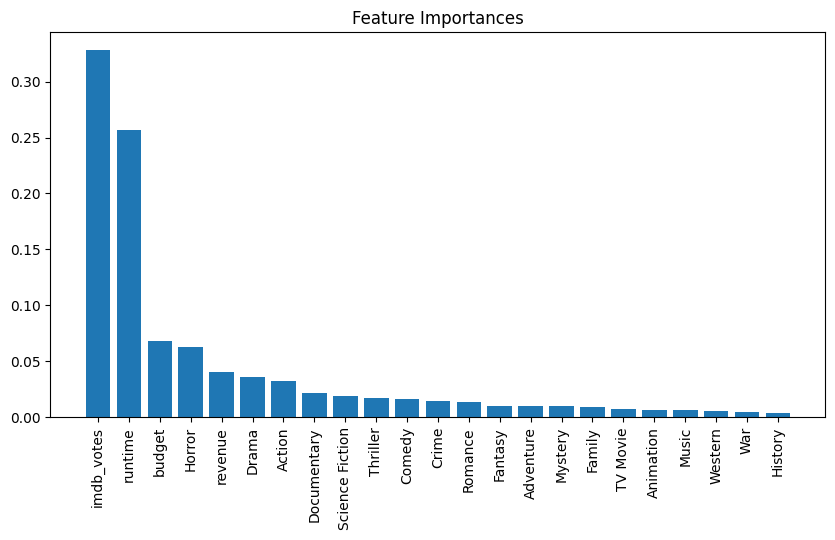

In [33]:
model = RandomForestRegressor()

import numpy as np

# Split the data into features and target
X = df_encoded[['revenue', 'runtime', 'budget', 'imdb_votes'] + list(one_hot.columns)]
y = df_encoded['imdb_rating']

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R^2: {r2}')

# Print the feature importances
importances = model.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.show()



In [ ]:
#Vilken variabel?
X_train, X_test, y_train, y_test = feature_view.train_test_split()